# Herschel Stripe 82 master catalogue
## Preparation of VISTA/CFHT Telescope / VIRCAM/WIRCAM Camera data

VISTA/CFHT Telescope / VIRCAM/WIRCAM Camera VICS82 catalogue: the catalogue comes from `dmu0_VICS82`.

The catalogue is described here: https://arxiv.org/pdf/1705.05451.pdf

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band.
- The auto magnitude to be used as total magnitude .



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "vics82_ra"
DEC_COL = "vics82_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'VICS82ID': "vics82_id",
        'ALPHA_J2000': "vics82_ra",
        'DELTA_J2000': "vics82_dec",
        'CLASS_STAR':  "vics82_stellarity",
        'MAG_AUTO': "m_vics82_k", 
        'MAG_APER': "m_ap_vics82_k", 
        'JMAG_AUTO': "m_vics82_j", 
        'JMAG_APER': "m_ap_vics82_j", 
})

#No error column?

catalogue = Table.read("../../dmu0/dmu0_VICS82/data/VICS82_FULL_SDSS_FEB2017_K22_HELP-coverage_intIDs.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2011

# Clean table metadata
catalogue.meta = None

#replace list of aperture magnitudes with appropriate choice from list
# Apertures (1", 1.5", 2", 2.5" and 3"
catalogue["m_ap_vics82_j"] = catalogue["m_ap_vics82_j"][:, 2]
catalogue["m_ap_vics82_k"] = catalogue["m_ap_vics82_k"][:, 2]
#catalogue["m_ap_vics82_j"]  = [el[0] for el in catalogue["m_ap_vics82_j"] ]
#catalogue["m_ap_vics82_j"]  = [el[0] for el in catalogue["m_ap_vics82_j"] ]

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        # Add err col with all nan values because errors absent
        errcol = "merr{}".format(col[1:])
        nan_values = np.empty(len(catalogue))
        nan_values[:] = np.NAN
        catalogue.add_column(Column(nan_values, name=errcol))
        
        # Some object have a magnitude to 0, we suppose this means missing value
        catalogue[col][catalogue[col] <= 0] = np.nan
        catalogue[errcol][catalogue[errcol] <= 0] = np.nan  
        

        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, oper)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, oper)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, oper)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, oper)(other)


In [6]:
catalogue[:10].show_in_notebook()

idx,vics82_id,vics82_ra,vics82_dec,vics82_stellarity,m_vics82_k,m_ap_vics82_k,m_vics82_j,m_ap_vics82_j,merr_vics82_k,f_vics82_k,ferr_vics82_k,flag_vics82_k,merr_ap_vics82_k,f_ap_vics82_k,ferr_ap_vics82_k,merr_vics82_j,f_vics82_j,ferr_vics82_j,flag_vics82_j,merr_ap_vics82_j,f_ap_vics82_j,ferr_ap_vics82_j
0,VICS82J232559.36+005108.1,351.49732411,0.85225400221,0.401309251785,21.2858448029,21.083,20.3085823059,20.7483,nan,11.1086703396,nan,False,nan,13.3903,nan,nan,27.32543458,nan,False,nan,18.2248,nan
1,VICS82J232559.42+002813.1,351.497565087,0.470317318592,0.503690361977,21.1304512024,21.2675,nan,nan,nan,12.8179779171,nan,False,nan,11.2976,nan,nan,nan,nan,False,nan,nan,nan
2,VICS82J232559.47+005959.5,351.497803536,0.99985073545,0.92281639576,20.2676105499,20.2314,nan,nan,nan,28.3763008554,nan,False,nan,29.3397,nan,nan,nan,nan,False,nan,nan,nan
3,VICS82J232559.50+005224.9,351.497933249,0.873569527564,0.464632093906,20.8858470917,21.0266,21.1511631012,21.4506,nan,16.0568800598,nan,False,nan,14.1051,nan,nan,12.5757750276,nan,False,nan,9.54477,nan
4,VICS82J232559.52+003956.3,351.497994705,0.665635285363,0.50468981266,20.6857585907,20.7009,20.8891906738,21.2878,nan,19.3061894567,nan,False,nan,19.0383,nan,nan,16.0075081079,nan,False,nan,11.089,nan
5,VICS82J232559.56+004148.7,351.498165292,0.696856016298,0.218787297606,19.8652000427,20.2629,20.5426464081,21.2157,nan,41.1073975326,nan,False,nan,28.4993,nan,nan,22.0262942544,nan,False,nan,11.8495,nan
6,VICS82J232559.59+002112.0,351.498288906,0.353335725929,0.200361967087,20.5464115143,20.3801,nan,nan,nan,21.9500439567,nan,False,nan,25.5838,nan,nan,nan,nan,False,nan,nan,nan
7,VICS82J232559.60+002103.2,351.498335769,0.350892097284,0.022700432688,17.5005187988,19.0342,15.1106052399,15.3616,nan,362.904606125,nan,False,nan,88.3735,nan,nan,3279.12448502,nan,False,nan,2602.22,nan
8,VICS82J232559.62+003108.3,351.498435232,0.518979207481,0.45001411438,20.3803386688,20.5136,20.6559696198,21.201,nan,25.5778792315,nan,False,nan,22.6226,nan,nan,19.8432202151,nan,False,nan,12.0115,nan
9,VICS82J232559.63+001902.7,351.498459364,0.317420541512,0.421070426702,22.2031841278,21.1348,nan,nan,nan,4.77228474854,nan,False,nan,12.7667,nan,nan,nan,nan,False,nan,nan,nan


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['m_ap_vics82_j', 'm_ap_vics82_k']
FLAG_NAME = 'vics82_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 41273 sources.
The cleaned catalogue has 41273 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Herschel-Stripe-82.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

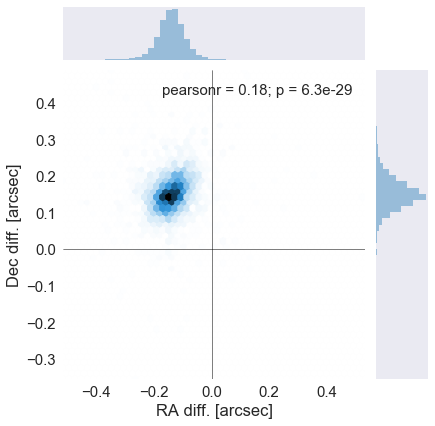

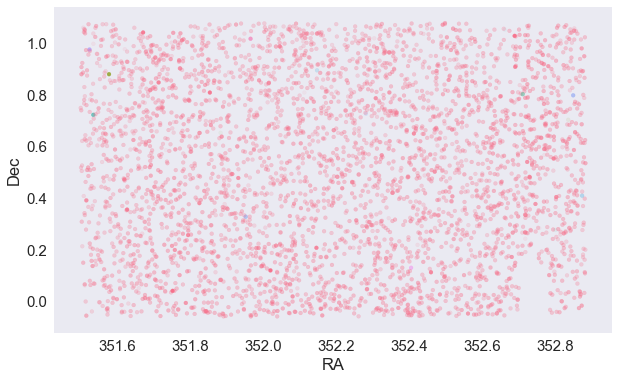

In [10]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.13989107385441457 arcsec
Dec correction: -0.14868115070041377 arcsec


In [12]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

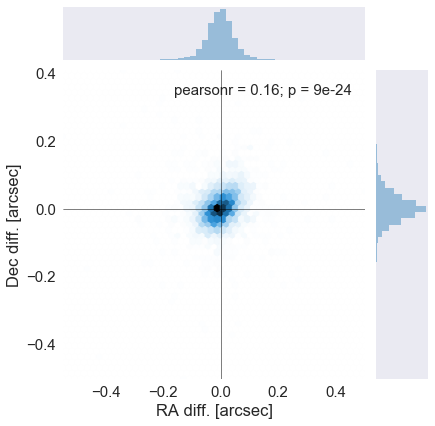

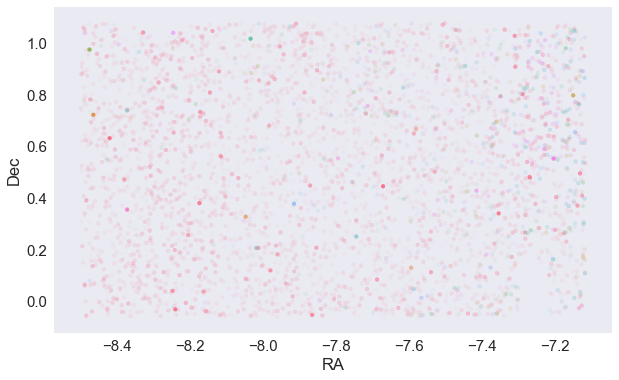

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [14]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [15]:
GAIA_FLAG_NAME = "vics82_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

3853 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [16]:
catalogue.write("{}/VICS82.fits".format(OUT_DIR), overwrite=True)